# Computational physics problem set 3

In [396]:
# import all the fun stuff
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Problem 1

We'll start by building the standard Runge-Kutta ODE solver that computes the new $y$ value after a given step $h$:

In [142]:
def rk4_step(fun,x,y,h):
    """
    RK4 prototype that takes in one step
    """
    # evaluate rk4 step
    k1 = fun(x,y) * h
    k2 = h * fun(x+h/2,y+k1/2)
    k3 = h * fun(x+h/2,y+k2/2)
    k4 = h * fun(x+h,y+k3)
    dy = (k1 + 2*k2 + 2*k3 + k4)/6
    
    return y+dy

In [143]:
def rk4_integrate(fun,x0,xf,y0,num,return_count=False):
    """
    Solve an ODE `fun` with initial conditions x0, y0 and `num` steps to xf.
    Returns x and y arrays.
    """
    # set count to 0
    count = 0
    
    # dress an array of x-values
    x = np.linspace(x0, xf, num+1) # add 1 because of endpoint
    
    # from those, compute the step size
    h = np.median(np.diff(x))
    
    # make an array of y values to fill
    y = np.zeros(num+1)
    
    # define the initial value
    y[0] = y0
    
    # take a step of size h and compute the new y value usig rk4
    for i in range(num): # there are a total of num_steps steps
        y[i+1] = rk4_step(fun1,x[i],y[i],h)
        count += 4
        
    if return_count:
        return x, y, count
        
    else:
        return x, y

In [144]:
def fun1(x,y):
    """
    ODE for problem 1
    """
    dydx = y / (1 + x**2)
    return dydx

def fun1_analytic(x,x0,y0):
    """
    The analytic solution to fun1
    """
    c0 = y0 / np.exp(np.arctan(x0))
    return c0 * np.exp(np.arctan(x))

In [145]:
x0 = -20
xf = 20
y0 = 1
num = 200
x_rk4, y_rk4 = rk4_integrate(fun1,x0=x0,xf=xf,y0=y0,num=num)
y_analytic = fun1_analytic(x_rk4,x0,y0)

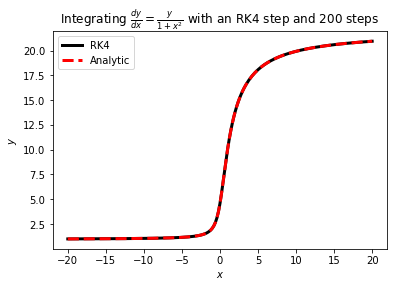

In [146]:
plt.figure()
plt.title(r"Integrating $\frac{dy}{dx} = \frac{y}{1+x^2}$ with an RK4 step and "+ str(num_steps) +" steps")
plt.plot(x_rk4,y_rk4,c='k',lw=3,label="RK4")
plt.plot(x_rk4,y_analytic,c='r',ls='--',lw=3,label="Analytic")
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

To get an idea of the relative error, we can compute the mean of `y_analytic - y_rk4`:

In [81]:
np.mean(y_analytic-y_rk4)

0.00011380566013480392

This is not bad, but not great. We would now like to build a *better* rk4 step that compares a step of length $h$ to two steps of length $h/2$. In the RK4 method, the error scales as $h^4$ (similar to Simpson's rule). We can use this to our advantage, since $y(x+h) = y_{\mathrm{true}} + a h^4$ and $y(x+\frac{h}{2}) = y_{\mathrm{true}} + a \frac{h^4}{16}$, therefore
\begin{equation}
y_{\mathrm{true}} = \frac{16y(x+h/2) - y(x+h)}{15}
\end{equation}
up to fifth order now. This is a very similar trick to the one we pulled to get better integrals.

In [151]:
def rk4_stepd(fun,x,y,h):
    """
    RK4 step that cancels leading order error by comparing intervals h and h/2
    There are a total of 12 function calls here
    """
    # first type: step size h
    # this is tested and works
    y_h = rk4_step(fun,x,y,h) # <- 4 calls
    
    # second type: two steps of sizes h/2
    # this is tested and works
    y_mid = rk4_step(fun,x,y,h/2) # <- 4 calls
    x_mid = x + h/2
    y_h2 = rk4_step(fun,x_mid,y_mid,h/2) # <- 4 calls
    
    # compute ytrue based on the 4th order error cancellation
    y_true = (16*y_h2 - y_h) / 15
        
    return y_true

In [152]:
def rk4_integrated(fun,x0,xf,y0,num,return_count=False):
    """
    Solve an ODE `fun` with initial conditions x0, y0 and `num` steps to xf.
    Returns x and y arrays.
    Uses refined rk4_stepd instead of rk4_step
    """
    # set count to 0
    count = 0
    
    # dress an array of x-values
    x = np.linspace(x0, xf, num+1) # add 1 because of endpoint
    
    # from those, compute the step size
    h = np.median(np.diff(x))
    
    # make an array of y values to fill
    y = np.zeros(num+1)
    
    # define the initial value
    y[0] = y0
    
    # take a step of size h and h/2 and compute the new y value usig rk4_stepd
    for i in range(num): # there are a total of num_steps steps
        y[i+1] = rk4_stepd(fun1,x[i],y[i],h)
        count += 12 # there are a total of 12 function calls in rk4_stepd
        
    if return_count:
        return x, y, count
    
    else:
        return x, y

In [153]:
x_rk4d, y_rk4d = rk4_integrated(fun1,x0=x0,xf=xf,y0=y0,num=num)

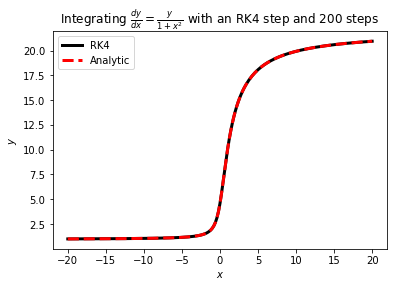

In [154]:
plt.figure()
plt.title(r"Integrating $\frac{dy}{dx} = \frac{y}{1+x^2}$ with an RK4 step and "+ str(num_steps) +" steps")
plt.plot(x_rk4,y_rk4,c='k',lw=3,label="RK4")
plt.plot(x_rk4,y_analytic,c='r',ls='--',lw=3,label="Analytic")
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

In [155]:
np.mean(y_analytic-y_rk4d)

-2.0613363189614818e-07

The error is much lower than before! The number of function calls for `rk4_stepd` is three times as many as for `rk4_step`, since we evaluate the function at $x+h$ and also at $x+h/2 \equiv x_{m}$, $x_m + h/2$. Moreover, a single `rk4_step` evaluation has 4 total function calls per step and `num = 200` steps, for a total of $800$ steps. Therefore, `rk4_stepd` has $2400$ function calls:

In [156]:
x_rk4, y_rk4, count = rk4_integrate(fun1,x0=x0,xf=xf,y0=y0,num=num,return_count=True)
x_rk4d, y_rk4d, countd = rk4_integrated(fun1,x0=x0,xf=xf,y0=y0,num=num,return_count=True)

In [160]:
print("Number of function calls in normal rk4 routine: {}".format(count))
print("Number of function calls in new rk4 routine: {}".format(countd))

Number of function calls in normal rk4 routine: 800
Number of function calls in new rk4 routine: 2400


as expected. So, to use the same number of function calls in `rk4_stepd`, we need to decrease the number of steps `num` by a factor of 3:

In [161]:
new_num = int(num / 3)

Let's run the routines for each and compare the errors for the same number of function calls:

In [169]:
x_rk4, y_rk4, count = rk4_integrate(fun1,x0=x0,xf=xf,y0=y0,num=num,return_count=True)
x_rk4d, y_rk4d, countd_new = rk4_integrated(fun1,x0=x0,xf=xf,y0=y0,num=new_num,return_count=True)
y_analytic_new = fun1_analytic(x_rk4d,x0,y0)

In [172]:
print("Error using normal rk4 routine: {}".format(np.mean(y_analytic-y_rk4)))
print("Error using new rk4 routine: {}".format(np.mean(y_analytic_new-y_rk4d)))

Error using normal rk4 routine: 0.00011380566013480392
Error using new rk4 routine: -8.846298835413463e-06


The error is indeed much smaller using the new routine with the same number of function calls. Let's check that the function calls are indeed more or less the same:

In [173]:
print("Number of function calls in normal rk4 routine: {}".format(count))
print("Number of function calls in new rk4 routine: {}".format(countd_new))

Number of function calls in normal rk4 routine: 800
Number of function calls in new rk4 routine: 792


Indeed, the number of function calls is in fact lesser in the new routine, and it still has a smaller error! In conclusion, the second method (using step sizes $h$ and $h/2$ and cancelling out the erros) is more accurate for a given number of step sizes.

## Problem 2

### a)

There are a few ways we can tackle this problem. The simplest is to go through each equation, solving for a single $N(t)$ along the way. The equations in question are
\begin{gather}
\dot{N}_{U-238} = - \lambda_{U-238} N_{U-238} \\
\dot{N}_{Th-234} = - \lambda_{Th-234} N_{Th-234} + \lambda_{U-238} N_{U-238} \\
\dots \\
\dot{N}_{Pb-206} = + \lambda_{Po-210} N_{Po-210}
\end{gather}
where we haven't written out all of the middle ones. So, seeing this, one can start from the first equation and work their way down, solving for $N$ along the way. Equivalently, we can dress this problem as a linear matrix ODE with constant coefficients:
\begin{equation}
\dot{\mathbf{N}}(t) = \mathbf{\Lambda} \cdot \mathbf{N}(t)
\end{equation}
where $\mathbf{N}$ is the vector of all $N$s and $\mathbf{\Lambda}$ is the matrix containing the information on half-lifes (equivalently, decay constants). We'll go ahead and solve this problem the second way, since that is probably the more "computational" way of doing things as opposed to the more "analytical" way of simply going through each equation and solving a one-line ODE.

To do so, first define the right-hand-side of each of the 15 equations into one single vectorized function. We will also use the `method = 'Radau'` option, as our equations will be stiff due to the wildly varying timescales.

In [467]:
# express it all in years
year_microsec = 1 / (24 * 3600 * 365) * 10**(-6)
year_minute = 1 / (365 * 24 * 60)

U238_hl = 4.468 * 10**9 # originally in billions of years
Th234_hl = 24.10 * 1 / (365) # originally in days
Pr234_hl = 6.70 * 1 / (365 * 24) # originally in hours
U234_hl = 245500 # originally in years
Th230_hl = 75380 # originally in years
Ra226_hl = 1600 # originally in years 
Rd222_hl = 3.8235 * 1 / (365) # originally in days
Po218_hl = 3.10 * year_minute # originally in minutes
Pb214_hl = 26.8 * year_minute # originally in minutes
Bi214_hl = 19.9 * year_minute # originally in minutes
Po214_hl = 164.3 * year_microsec
Pb210_hl = 22.3 # originally in years 
Bi210_hl = 5.015 # originally in years 
Po210_hl = 138.376 * 24.10 * 1 / (365) # originally in days

halflifes = [U238_hl,Th234_hl,Pr234_hl,U234_hl,Th230_hl,Ra226_hl,Rd222_hl,
             Po218_hl,Pb214_hl,Bi214_hl,Po214_hl,Pb210_hl,Bi210_hl,Po210_hl]

In [468]:
# define vectorized function
def vectorized_decay(x,y,half_life=halflifes):
    """
    Matrix of ODEs to solve
    every decay in the U-238 -- Pb-206 chain is included
    """
    # size of half-life array
    n = len(half_life)
    
    # initialize jacobian array
    dydx = np.zeros(n+1) # +1 for lead which doesn't have a half life
    
    # do the endpoints which only have one process
    dydx[0] = - y[0] / half_life[0] # first case of only uranium
    dydx[n] = y[n-1] / half_life[n-1] # last case of lead: only polonium
    
    # middle cases: both gain and decay
    for i in range(1,n): # note that the case i = n is not considered here (halflife[n] does not exist)
        dydx[i] = y[i-1] / half_life[i-1] - y[i] / half_life[i]
        
    return dydx

In [469]:
# make the initial values of y
n = len(halflifes)
y0 = np.zeros(n+1,dtype=float)
y0[0] = 1
# and set the time range
x0 = 0
xf = 10**9

ans_decay = solve_ivp(fun=vectorized_decay,t_span=[x0,xf],y0=y0,method='Radau')

print(ans_decay)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 100
     njev: 1
      nlu: 28
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.68593953e+00, 1.85453348e+01, 1.87139288e+02,
       1.87307882e+03, 1.87324741e+04, 1.87326427e+05, 5.07933577e+05,
       1.10213323e+06, 2.04850860e+06, 4.20192363e+06, 1.29454104e+07,
       7.58042949e+07, 7.04393140e+08, 1.00000000e+09])
 t_events: None
        y: array([[1.00000000e+00, 1.00000000e+00, 9.99999996e-01, 9.99999958e-01,
        9.99999581e-01, 9.99995807e-01, 9.99958075e-01, 9.99886324e-01,
        9.99753358e-01, 9.99541621e-01, 9.99059994e-01, 9.97106832e-01,
        9.83177067e-01, 8.54146209e-01, 7.99463992e-01],
       [0.00000000e+00, 1.38952925e-11, 1.47681416e-11, 1.47778299e-11,
        1.47778356e-11, 1.47777799e-11, 1.47772223e-11, 1.47761619e-11,
        1.47741970e-11, 1.47710680e-11, 1.47639506e-11, 1.47350870e-11,
        1.45292352e-11, 1.26224376e

This is the program that solves for the decay products of U-238 using the scipy ODE solver `solve_ivp` in vectorized form. Next, we will see the solutions explicitly.

### b)

First, we want to plot the ratio of Pb206 to U238 over a region of time where it is interesting. Since the half-life of U238 is on the order of a Billion years, let's look between one billion and one billion plus one million years (enough to have the other decay products flow through).

In [470]:
# make the initial values of y
n = len(halflifes)
y0 = np.zeros(n+1,dtype=float)
y0[0] = 1 # only U238 at first
# and set the time range of interest (this will be on the scale of U238 decay)
x0 = 10**9
xf = 10**9 + 10**6

ans_decay = solve_ivp(fun=vectorized_decay,t_span=[x0,xf],y0=y0,method='Radau')

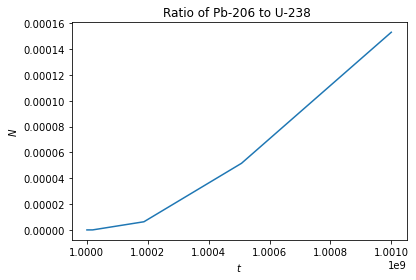

In [471]:
plt.title("Ratio of Pb-206 to U-238 ")
plt.ylabel(r"$N$")
plt.xlabel(r"$t$")
plt.plot(ans_decay.t,ans_decay.y[14,:]/ans_decay.y[0,:])
plt.show()

It makes sense that the ratio would look exponential. Since the halflife of Uranium-238 is so long compared to anything else, it can be seen as decaying instantly to lead:
\begin{gather} 
\dot{N}_{U238} = \frac{-1}{t_{U238}} N_{U238}\\
\dot{N}_{Pb} = \frac{1}{t_{U238}} N_{U238}.
\end{gather}
Solving for both leads to $N_{Pb} = N_{U238}(0)(1-e^{-t/t_{U238}})$. This exponential behaviour is seen in the plot above. So, our analytical expectation is met.

Now, let's look at the ration between Thorium-230 and U-234. Since both of their half-lives are on the order of a few tens-to-a-hundred tousand years, let's look between $10^4$ and $10^7$.

/var/folders/9r/bpr4jkd977j2221xz84wjlzm0000gn/T/ipykernel_26090/2833110572.py:15: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(ans_decay.t,ans_decay.y[4,:]/ans_decay.y[3,:])


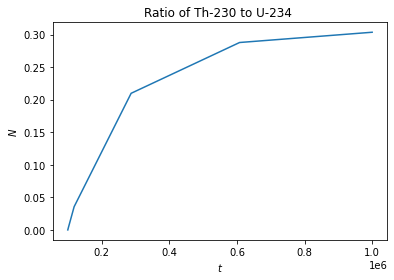

In [473]:
# make the initial values of y
n = len(halflifes)
y0 = np.zeros(n+1,dtype=float)
y0[0] = 1
# and set the time range of interest (this will be on the scale of U238 decay)
x0 = 10**5
xf = 10**6

ans_decay = solve_ivp(fun=vectorized_decay,t_span=[x0,xf],y0=y0,method='Radau')

# thorium is index 4 and U234 is index 3
plt.title("Ratio of Th-230 to U-234 ")
plt.ylabel(r"$N$")
plt.xlabel(r"$t$")
plt.plot(ans_decay.t,ans_decay.y[4,:]/ans_decay.y[3,:])
plt.show()

and the ratio of their densities is relatively constant for large time-scales. Now, we can tackle this problem analytically as well by simply diagonalizing a matrix of ODEs:

In [474]:
# how many elements are we dealing with here?
n = len(halflifes) + 1 # add 1 for the Pb which has no half-life
# make the matrix A
A = np.zeros((n,n),dtype=float)

# fill it uo
for i in range(n-1):
    A[i,i] = -1 / halflifes[i] # fill up the diagonals with -1/t except for the last point
    A[i+1,i] = 1 / halflifes[i] # fill up the bottom off diagonals with 1/t 
A[-1,-1] = 0 # last diagonal is zero

ev, evec = np.linalg.eig(A) # evec is a matrix of eigvectors s.t. evec[:,i] is the ith eigvec

# find the value of each coefficient by inverting the matrix of vectors and dotting it with N0
N0 = np.zeros(n,dtype=float)
N0[0] = 1
Cs = np.linalg.pinv(evec) @ N0

# write out the solution as a linear combination
def N(t,element):
    N = 0
    for i in range(n):
        N += Cs[i] * np.exp(ev[i] * t) * evec[:,i][element]
    return N

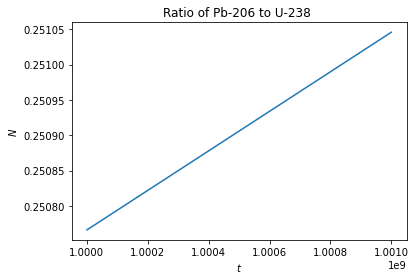

In [478]:
# ratio of lead to uranium
ts = np.linspace(10**9,10**9+10**6,num=1000)
ratio = N(ts,element=14) / N(ts,element=0)


plt.title("Ratio of Pb-206 to U-238 ")
plt.ylabel(r"$N$")
plt.xlabel(r"$t$")
plt.plot(ts,ratio)
plt.show()

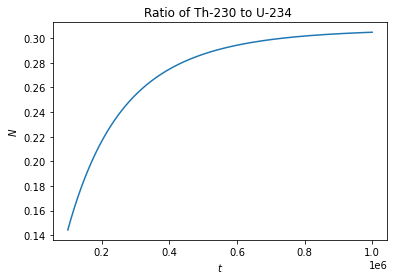

In [479]:
ts = np.linspace(10**5,10**6,num=1000)
ratio = N(ts,element=4) / N(ts,element=3)

plt.title("Ratio of Th-230 to U-234 ")
plt.ylabel(r"$N$")
plt.xlabel(r"$t$")
plt.plot(ts,ratio)
plt.show()

These plots match the ones found in a more computational way.

## Problem 3

### a)

To find the new parameters that make the system linear, first expand the function:
\begin{equation}
z = z_0 + a(x^2+y^2) - 2xax_0 - 2y a y_0 + a(x_0^2+y_0^2).
\end{equation}
Now, the non-linear parts are $- 2xax_0 - 2y a y_0 + a(x_0^2+y_0^2)$, since they depend on the square or product of parameters (note that the square of data is fine -- it is linearity in the parameters that we seek). To this end, we define the variables
\begin{gather}
u = a x_0, \\
v = a y_0, \\
w = z_0 + a (x_0^2+y_0^2).
\end{gather}
The equation is now:
\begin{equation}
\boxed{
z = w + a(x^2+y^2) - 2xu - 2y v},
\end{equation}
linear in $a,u,v,w$. To dress the problem as a matrix, write:
\begin{equation}
\mathbf{z} = \mathbf{A} \cdot \mathbf{m}
\end{equation}
where $\mathbf{z} = (z_1,\dots,z_n)^T$, $\mathbf{m} = (u,v,w,a)^T$ and
\begin{equation}
\mathbf{A} = 
\begin{pmatrix}
-2x_1 & -2y_1 & 1 & x_1^2 + y_1^2 \\
\vdots & \vdots & \vdots & \vdots \\
-2x_n & -2y_n & 1 & x_n^2 + y_n^2
\end{pmatrix}.
\end{equation}
To solve this, we simply use the whole linear least squares formalism with our refined variables and then switch back to the correct variables, propagating error along the way.

### b)
 To solve this, we simply use the whole linear least squares formalism with our refined variables and then switch back to the correct variables, propagating error along the way.

In [481]:
# first, load the data
data = np.loadtxt("dish_zenith.txt", delimiter=" ")
x = data[:,0]
y = data[:,1]
z = data[:,2]

In [482]:
# next, perform the fit

# there are 4 parameters
deg = 4

# make the A matrix
A = np.zeros([len(z),deg])
A[:,0] = -2*x
A[:,1] = -2*y
A[:,2] = 1
A[:,3] = x**2 + y**2

# perform the fit
lhs = A.T@A
rhs = A.T@z
u, v, w, a = np.linalg.inv(lhs)@rhs # these are the parameters
pred = A@fitp # these are the predicted z values

In [483]:
# switch back to our variables of interest
x0 = u/a
y0 = v/a
z0 = w - a*(x0**2 + y0**2)
print("The best fit parameters are: x0 = {}, y0 = {}, z0 = {}, a = {}".format(x0,y0,z0,a))

The best fit parameters are: x0 = -1.3604886221692303, y0 = 58.221476081579986, z0 = -1512.877210036791, a = 0.00016670445477401434


We will estimate the error of $a$ below.

### c)

Now, estimate the error by using the same machinary as seen in class: take the covariance matrix to be the squared of the residuals alogn the diagonals and go through the motions, multiplying it by the left hand side $A^T \cdot A$:

In [484]:
# compute covariance matix
N = np.mean((z-pred)**2)

# parameter errors
par_errs = np.sqrt(N*np.diag(np.linalg.inv(lhs)))
print("The error in a {}".format(par_errs[3]))

# data errors
tmp=A@np.linalg.inv(lhs)@A.T
mod_err=np.sqrt(N*np.diag(tmp))

The error in a 6.451899757263472e-08


Since the focal length for a parabola is $z = x^2/(4f)$, we can determine it from our parameters as simply
$$ f = \frac{1}{4a}.$$

In [485]:
focal_length = 1/(4*a)
print(focal_length)

1499.6599841252091


The error is $\frac{1}{4 a^2} \Delta a$, found by using a first order Taylor expansion (or, just taking the differential and leaving $\Delta a$).

In [486]:
a_err = par_errs[3]
focal_length_error = 1/4 * 1/(a)**2 * a_err 
print(focal_length_error)

0.5804077581892795


So, we find $1499.7 \pm 0.6 $ mm, just slightly inconsistent with the expected value of $1.5$m.